# Bayesian NN


TODOs
- then test with curriculum
    

# Useful Links
- cifar ex https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/cifar10_bnn.py
- uses resnet https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/models/bayesian_resnet.py
- http://krasserm.github.io/2019/03/14/bayesian-neural-networks/
- https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py





In [1]:
from epitome.constants import *
from epitome.models import *
from epitome.generators import *
from epitome.functions import *
from epitome.viz import *
from sklearn.metrics import roc_curve, auc
assert(tf.executing_eagerly())
import tensorflow_probability as tfp
import yaml

/data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# load in user paths
# TODO: make a config file with data_path (downloaded from bin/download_deepsea_data.py) 
# and feature_name_file (at data/feature_name)
# My config.yml looks like:
# data_path: /data/akmorrow/epitome_data/numpy_data/
# feature_name_file: /home/eecs/akmorrow/epitome/data/feature_name

with open('/home/eecs/akmorrow/epitome/config.yml') as f:
    config = yaml.safe_load(f)
    
train_data, valid_data, test_data = load_deepsea_label_data(config["data_path"])
data = {Dataset.TRAIN: train_data, Dataset.VALID: valid_data, Dataset.TEST: test_data}
print(data[Dataset.TRAIN].shape, data[Dataset.VALID].shape, data[Dataset.TEST].shape)

(919, 2200000) (919, 4000) (919, 227512)


## Plot Data Matrix

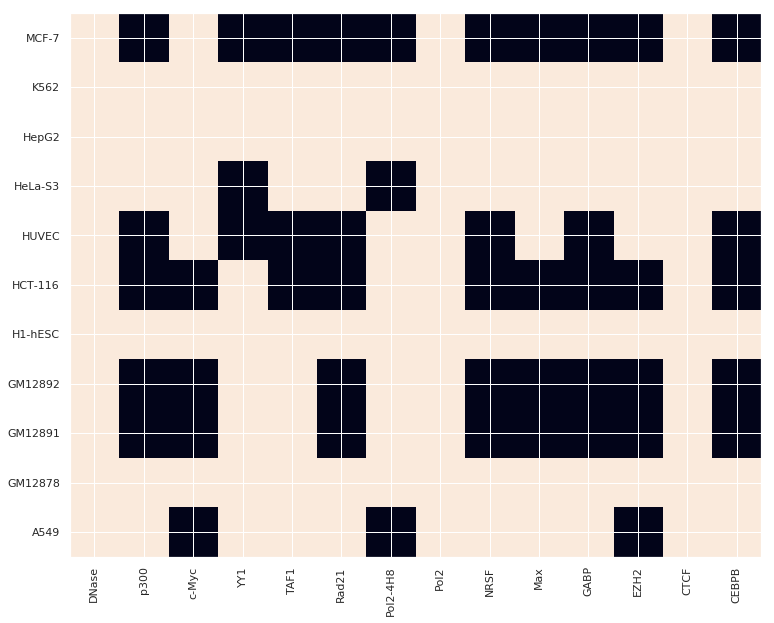

In [3]:
# matrix, cellmap, assaymap = get_assays_from_feature_file(eligible_assays = ['DNase','CTCF'],
#                                   eligible_cells = None)

matrix, cellmap, assaymap = get_assays_from_feature_file(eligible_assays = None,
                                  eligible_cells = None, min_cells_per_assay =6, 
                                                         min_assays_per_cell=7)

nv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=Label.UNK.value)

In [4]:

# def load_data(data, 
#                  label_cell_types,  # used for labels. Should be all for train/eval and subset for test
#                  eval_cell_types,   # used for rotating features. Should be all - test for train/eval
#                  matrix,
#                  assaymap,
#                  cellmap,
#                  radii,
#                  **kwargs):
    
#     # AM 5/20/2019. This is enforcing exclusive DNase bins and will make 
#     # interpretation of DNase weights easier. It does not add performance benefit
#     # over inclusive bins, which was used in the original model.
#     exclusive = True

#     """
#     Takes Deepsea data and calculates distance metrics from cell types whose locations
#     are specified by label_cell_indices, and the other cell types in the set. Label space is only one cell type.
#      TODO AM 3/7/2019
#     :param data: dictionary of matrices. Should have keys x and y. x contains n by 1000 rows. y contains n by 919 labels.
#     :param label_cell_types: list of cell types to be rotated through and used as labels (subset of eval_cell_types)
#     :param eval_cell_types: list of cell types to be used in evaluation (includes label_cell_types)
#     :param matrix: matrix of celltype, assay positions
#     :param assaymap: map of column assay positions in matrix
#     :param cellmap: map of row cell type positions in matrix
#     :param radii: radii to compute dnase distances from
#     :param kwargs: kargs

#     :returns: generator of data with three elements:
#         1. record features
#         2. record labels for a given cell type
#         3. 0/1 mask of labels that have validation data. For example, if this record is for celltype A549,
#         and A549 does not have data for ATF3, there will be a 0 in the position corresponding to the label space.
#     """

#     # Running in TRAIN, VALID, or TEST?    
#     mode = kwargs.get("mode")
#     # specifies the indices to generate records.
#     # can be used for debug purposes, or to evaluate
#     # only specific regions in a vector
#     # TODO AM 4/17/2019: move this to an actual parameter
#     indices = kwargs.get("indices")
    
#     if (not isinstance(indices, np.ndarray) and not isinstance(indices, list)):
#         indices = range(0, data.shape[-1]) # if not defined, set to all points
    
#     if (not isinstance(mode, Dataset)):
#         raise ValueError("mode is not a Dataset enum")
        
#     if (mode == Dataset.RUNTIME):
#         label_cell_types = ["PLACEHOLDER_CELL"]
#         dnase_vector = kwargs.get("dnase_vector")
#         random_cell = list(cellmap)[0] # placeholder to get label vector length
        
#     print("using %s as labels for mode %s" % (label_cell_types, mode))
    
#     # string of radii for meta data labeling
#     radii_str = list(map(lambda x: "DNASE_RADII_%i" % x, radii))
        
#     if (mode == Dataset.TEST or mode == Dataset.RUNTIME):
#         # Drop cell types with the least information (TODO AM 4/1/2019 this could do something smarter)
        
#         # make dictionary of eval_cell_type: assay count and sort in decreasing order
#         tmp = matrix.copy()
#         tmp[tmp>= 0] = 1
#         tmp[tmp== -1] = 0
#         sums = np.sum(tmp, axis = 1)
#         cell_assay_counts = zip(list(cellmap), sums)
#         cell_assay_counts = sorted(cell_assay_counts, key = lambda x: x[1])
#         # filter by eval_cell_types
#         cell_assay_counts = list(filter(lambda x: x[0] in eval_cell_types, cell_assay_counts))
        
#         # remove cell types with smallest number of factors
#         eval_cell_types = eval_cell_types.copy()
#         [eval_cell_types.remove(i[0]) for i in cell_assay_counts[0:len(label_cell_types)]]
#         del tmp
#         del cell_assay_counts
        
        
#     def g():
#         for i in indices: # for all records specified
#             for (cell) in label_cell_types: # for all cell types to be used in labels
#                 dnases = [] 
#                 dnases_double_positive = []
#                 dnases_agreement = []
                
#                 # cells to be featurized
#                 feature_cells = eval_cell_types.copy()
                
#                 # try to remove cell if it is in the possible list of feature cell types
#                 try:
#                     feature_cells.remove(cell) 
#                 except ValueError:
#                     pass  # do nothing!
                                
#                 # features from all remaining cells not in label set
#                 feature_cell_indices_list = list(map(lambda c: get_y_indices_for_cell(matrix, cellmap, c), 
#                                                      feature_cells))
#                 feature_cell_indices = np.array(feature_cell_indices_list).flatten()
                
#                 # labels for this cell
#                 if (mode != Dataset.RUNTIME):
#                     label_cell_indices = get_y_indices_for_cell(matrix, cellmap, cell)
#                     label_cell_indices_no_dnase = np.delete(label_cell_indices, [0])

#                     # Copy assay_index_no_dnase and turn into mask of 0/1 for whether data for this cell type for
#                     # a given label is available.
#                     assay_mask = np.copy(label_cell_indices_no_dnase)
#                     assay_mask[assay_mask == -1] = 0
#                     assay_mask[assay_mask > 0] = 1
                    
#                 else:
#                     label_count = len(get_y_indices_for_cell(matrix, cellmap, random_cell))-1
                    
#                     # Mask and labels are all 0's because labels are missing during runtime
#                     garbage_labels = assay_mask = np.zeros(label_count)

#                 # get dnase indices for cell types that are going to be features
#                 dnase_indices = np.array([x[0] for x in feature_cell_indices_list])
                
#                 for r, radius in enumerate(radii):
                    
#                     min_radius = max(0, i - radius + 1)
#                     max_radius = min(i+radius, data.shape[1])
                    
#                     # if exclusive == True, then do not featurize chromatin regions
#                     # that were considered in smaller radii
#                     if (exclusive and r != 0):
#                         radius_range_1 = np.arange(min_radius, max(0, i - radii[r-1]+1))
#                         radius_range_2 = np.arange(i+radii[r-1], max_radius)
                        
#                         radius_range = np.concatenate([radius_range_1, radius_range_2])
#                     else:
                        
#                         radius_range = np.arange(min_radius, max_radius)
                        
                        
#                     ####################################################################
                    
#                     # use DNase vector, if it is provided
#                     if (mode == Dataset.RUNTIME):

#                         # within the radius, fraction of places where they are both 1
#                         dnase_double_positive = np.average(data[dnase_indices[:,None],radius_range]*
#                                                  dnase_vector[radius_range], axis=1)

#                         # within the radius, fraction of places where they are both equal (0 or 1)
#                         dnase_agreement = np.average(data[dnase_indices[:,None],radius_range]==
#                                                  dnase_vector[radius_range], axis=1)

#                     else:
#                         # within the radius, fraction of places where they are both 1
#                         # label_cell_index[0] == DNase location for specific cell type
#                         dnase_double_positive = np.average(data[dnase_indices[:,None],radius_range]*
#                                                  data[label_cell_indices[0],radius_range], axis=1)

#                         # within the radius, fraction of places where they are both equal (0 or 1)
#                         dnase_agreement = np.average(data[dnase_indices[:,None],radius_range]==
#                                                  data[label_cell_indices[0],radius_range], axis=1)
                        
#                     dnases_double_positive.extend(dnase_double_positive)
#                     dnases_agreement.extend(dnase_agreement)
                        
#                 # rehape agreement DNase to Radii by feature_cells
#                 dnases_agreement_reshaped = np.array(dnases_agreement).reshape([len(radii), len(feature_cells)])
#                 dnases_double_positive_reshaped = np.array(dnases_double_positive).reshape([len(radii), len(feature_cells)])
#                 dnase_means = np.mean(dnases_agreement_reshaped, axis = 0)

#                 ######### reorder cells by similarity ################
#                 ## This was added 5/30/2019. It seems to *maybe help 
#                 ## a little bit on cell types not seen in the model.
#                 ## This makes sense because cell types are now ordered
#                 ## by similarity and keep some spacial positioning 
#                 ## based on the similarity to the new cell. 
#                 best_indices = (-dnase_means).argsort()

#                 dnases.extend(dnases_double_positive_reshaped[:,best_indices].flatten())
#                 dnases.extend(dnases_agreement_reshaped[:,best_indices].flatten())

#                 feature_cell_indices = feature_cell_indices.reshape([len(feature_cells), len(assaymap)])[best_indices,:].flatten()
#                 ######## End reorder #################################                                                   
                                                                        
                                                                        
#                 # Extract features
#                 features = data[feature_cell_indices,i]
                
#                 # concatenate features and DNases
#                 x_data = np.concatenate([features, dnases])
                
#                 # mask for x_data. 0 = do not mask, 1 = mask.
#                 x_mask = np.zeros(x_data.shape[0])
#                 x_mask[np.where(feature_cell_indices == -1)[0]] = True # assign mask to missing features

#                 # There can be NaNs in the DNases for edge cases (when the radii extends past the end of the chr).
#                 # Mask these values in the first row of tmp
#                 x_mask[np.where(np.isnan(x_data))[0]] = True # assign mask to missing DNase values
#                 x_data[np.where(x_mask == True)[0]] = 0 # set all UNKs to 0
                
#                 # mask x data by which factors are available for a cell type
#                 x_data_masked = np.vstack([x_mask, x_data]) # top row 0 = mask, bottom row 1 = data
                        
#                 if (mode != Dataset.RUNTIME):
#                     labels = data[label_cell_indices_no_dnase,i]

#                 else: # used when just predicting
#                     # The features going into the example.
#                     labels = garbage_labels # all 0's
                    
#                 yield (x_data_masked, labels, assay_mask)

#     return g


In [5]:
# import tqdm 

# class VariationalPeakModel():
#     def __init__(self,
#                  data,
#                  test_celltypes,
#                  matrix,
#                  assaymap,
#                  cellmap,  
#                  debug = False,
#                  batch_size=64,
#                  shuffle_size=10,
#                  prefetch_size=10,
#                  l1=0.,
#                  l2=0.,
#                  lr=1e-3,
#                  radii=[1,3,10,30], 
#                  train_indices = None):
        
#         """
#         Peak Model
#         :param data: either a path to TF records OR a dictionary of TRAIN, VALID, and TEST data
#         :param test_celltypes
#         :param matrix
#         :param assaymap
#         :param cellmap
#         :param debug: used to print out intermediate validation values
#         :param batch_size
#         :param shuffle_size
#         :param prefetch_size
#         :param l1
#         :param l2
#         :param lr
#         :param radii
#         :param train_indices: option numpy array of indices to train from data[Dataset.TRAIN]
#         """
        
#         tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

#         assert (set(test_celltypes) < set(list(cellmap))), \
#                 "test_celltypes %s must be subsets of available cell types %s" % (str(test_celltypes), str(list(cellmap)))

#         # get evaluation cell types by removing any cell types that would be used in test
#         self.eval_cell_types = list(cellmap).copy()
#         self.test_celltypes = test_celltypes
#         [self.eval_cell_types.remove(test_cell) for test_cell in self.test_celltypes]
#         print("eval cell types", self.eval_cell_types)

#         self.output_shape, self.train_iter = generator_to_tf_dataset(load_data(data[Dataset.TRAIN],  
#                                                 self.eval_cell_types,
#                                                 self.eval_cell_types,
#                                                 matrix,
#                                                 assaymap,
#                                                 cellmap,
#                                                 radii = radii, mode = Dataset.TRAIN),
#                                                 batch_size, shuffle_size, prefetch_size)

#         _,            self.valid_iter = generator_to_tf_dataset(load_data(data[Dataset.VALID], 
#                                                 self.eval_cell_types,
#                                                 self.eval_cell_types,
#                                                 matrix,
#                                                 assaymap,
#                                                 cellmap,
#                                                 radii = radii, mode = Dataset.VALID), 
#                                                 batch_size, 1, prefetch_size)

#         # can be empty if len(test_celltypes) == 0
#         _,            self.test_iter = generator_to_tf_dataset(load_data(data[Dataset.TEST], 
#                                                self.test_celltypes, 
#                                                self.eval_cell_types,
#                                                matrix,
#                                                assaymap,
#                                                cellmap,
#                                                radii = radii, mode = Dataset.TEST),
#                                                batch_size, 1, prefetch_size)

#         self.num_outputs = self.output_shape[0]
#         self.l1, self.l2 = l1, l2
#         self.lr = lr
#         self.batch_size = batch_size
#         self.prefetch_size = prefetch_size
#         self.shuffle_size = shuffle_size
#         self.optimizer =tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr)

#         # set self
#         self.model = self.create_model()
#         self.radii = radii
#         self.debug = debug
#         self.assaymap = assaymap
#         self.test_celltypes = test_celltypes
#         self.matrix = matrix
#         self.assaymap= assaymap 
#         self.cellmap = cellmap
#         self.data = data
            
#     def save(self, checkpoint_path):
#         """
#         Saves model.
        
#         :param checkpoint_path: string file path to save model to. 
#         """
#         # save keras model
#         self.model.save(checkpoint_path)
        
#         # save model params to pickle file
#         dict_ = {'test_celltypes':self.test_celltypes,
#                          'matrix':self.matrix,
#                          'assaymap':self.assaymap,
#                          'cellmap':self.cellmap,  
#                          'debug': self.debug,
#                          'batch_size':self.batch_size,
#                          'shuffle_size':self.shuffle_size,
#                          'prefetch_size':self.prefetch_size,
#                          'radii':self.radii}
        
#         fileObject = open(os.path.join(checkpoint_path, "model_params.pickle"),'wb')
#         pickle.dump(dict_,fileObject)   
#         fileObject.close()
        
        
#     def gini(self, actual, pred, sample_weight):                                                 
#         df = sorted(zip(actual, pred), key=lambda x : (x[1], x[0]),  reverse=True)
#         random = [float(i+1)/float(len(df)) for i in range(len(df))]                
#         totalPos = np.sum([x[0] for x in df])           
#         cumPosFound = np.cumsum([x[0] for x in df])                                     
#         Lorentz = [float(x)/totalPos for x in cumPosFound]                          
#         Gini = np.array([l - r for l, r in zip(Lorentz, random)])
#         # mask Gini with weights
#         Gini[np.where(sample_weight == 0)[0]] = 0
#         return np.sum(Gini)    

#     def gini_normalized(self, actual, pred, sample_weight = None):              
#         normalized_gini = self.gini(actual, pred, sample_weight)/self.gini(actual, actual, sample_weight)      
#         return normalized_gini       

#     def body_fn(self):
#         raise NotImplementedError()
        
#     def g(self, p, a=1, B=0, y=1):
#         """ Normalization Function. Normalizes loss w.r.t. label proportion.

#         Constraints: 
#          1. g(p) = 1 when p = 1
#          2. g(p) = a * p^y + B, where a, y and B are hyperparameters
#         """
#         return a * tf.math.pow(p, y) + B
    
#     def loss_fn(self, y_true, y_pred, weights):
#         # weighted sum of cross entropy for non 0 weights
#         # Reduction method = Reduction.SUM_BY_NONZERO_WEIGHTS
#         loss = tf.compat.v1.losses.sigmoid_cross_entropy(y_true,  
#                                                         y_pred[:, Features.FEATURE_IDX.value, :], 
#                                                         weights = weights,
#                                                         reduction = tf.compat.v1.losses.Reduction.SUM_BY_NONZERO_WEIGHTS)

#         C = (len(self.assaymap)-1)
#         # p = tf.math.reduce_sum(weights, axis=1)/C # should be of dimension 1 by batch size
#         p = 1.0 # this is just taking the mean loss, nothing special here.
#         return self.g(p)/C * loss
    
    
#     def train(self, num_steps, lr=None, checkpoint_path = None):
#         if lr == None:
#             lr = self.lr
            
#         tf.compat.v1.logging.info("Starting Training")

#         @tf.function
#         def train_step(inputs, labels, weights):
#             with tf.GradientTape() as tape:
#                 logits = self.model(inputs, training=True)
#                 kl_loss = sum(self.model.losses)
#                 neg_log_likelihood = self.loss_fn(labels, logits, weights)
#                 elbo_loss = neg_log_likelihood + kl_loss
            
#             gradients = tape.gradient(elbo_loss, self.model.trainable_variables)
#             self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

#             return elbo_loss, neg_log_likelihood, kl_loss

#         for step, (inputs, labels, weights) in enumerate(self.train_iter.take(num_steps)): 

#             loss = train_step(inputs, labels, weights)

#             if step % 1000 == 0:
#                 tf.compat.v1.logging.info(str(step) + " " + str(tf.reduce_mean(loss[0])) + 
#                                           str(tf.reduce_mean(loss[1])) +
#                                           str(tf.reduce_mean(loss[2])))
                
#                 if (self.debug):
#                     tf.compat.v1.logging.info("On validation")
#                     _, _, _, _, _ = self.test(40000, log=False)
#                     tf.compat.v1.logging.info("")

#     def test(self, num_samples, mode = Dataset.VALID, log=False):
#         """
#         Tests model on valid and test dataset handlers.
#         """

#         if (mode == Dataset.VALID):
#             handle = self.valid_iter # for standard validation of validation cell types
            
#         elif (mode == Dataset.TEST and len(self.test_celltypes) > 0):
#             handle = self.test_iter # for standard validation of validation cell types        
#         else:
#             raise Exception("No data exists for %s. Use function test_from_generator() if you want to create a new iterator." % (mode))
            
#         return self.run_predictions(num_samples, handle, log)      
        
#     def test_from_generator(self, num_samples, ds, log=False):
#         """
#         Runs test given a specified data generator 
#         :param num_samples: number of samples to test
#         :param ds: tensorflow dataset, created by dataset_to_tf_dataset
#         :param cell_type: cell type to test on. Used to generate holdout indices.
        
#         :return predictions
#         """
#         return self.run_predictions(num_samples, ds, log)
    
#     def eval_vector(self, data, vector, indices):
#         """
#         Evaluates a new cell type based on its chromatin (DNase or ATAC-seq) vector. len(vector) should equal
#         the data.shape[1]
#         :param data: data to build features from 
#         :param vector: vector of 0s/1s of binding sites TODO AM 4/3/2019: try peak strength instead of 0s/1s
#         :param indices: indices of vector to actually score. You need all of the locations for the generator.

#         :return predictions for all factors
#         """
        
#         _,  ds = generator_to_tf_dataset(load_data(data, 
#                  self.test_celltypes,   # used for labels. Should be all for train/eval and subset for test
#                  self.eval_cell_types,   # used for rotating features. Should be all - test for train/eval
#                  self.matrix,
#                  self.assaymap,
#                  self.cellmap,
#                  radii = self.radii,
#                  mode = Dataset.RUNTIME,
#                  dnase_vector = vector, indices = indices), self.batch_size, 1, self.prefetch_size)

#         num_samples = len(indices)
        
#         preds, _, _, _, _ = self.run_predictions(num_samples, ds, False, calculate_metrics = False)    
        
#         return preds

#     def run_predictions(self, num_samples, iter_, log, calculate_metrics = True, samples = 500):
#         """
#         Runs predictions on num_samples records
#         :param num_samples: number of samples to test
#         :param iter_: output of self.sess.run(generator_to_one_shot_iterator()), handle to one shot iterator of records
#         :param log: if true, logs individual factor accuracies
        
#         :return preds, truth, assay_dict, auROC, auPRC, False
#             preds = predictions, 
#             truth = actual values, 
#             sample_weight: 0/1 weights on predictions.  
#             assay_dict = if log=True, holds predictions for individual factors
#             auROC = average macro area under ROC for all factors with truth values
#             auPRC = average area under PRC for all factors with truth values
#         """
        
#         inv_assaymap = {v: k for k, v in self.assaymap.items()}
                        
#         # batches of predictions
#         vals = []

#         # Calculate epistemic uncertainty by iterating over a certain number of times,
#         # getting y_preds. You can then calculate the mean and sigma of the predictions, 
#         # and use this to gather uncertainty: (see http://krasserm.github.io/2019/03/14/bayesian-neural-networks/)
#         # inputs, truth, sample_weight
#         vals = [(i[0],i[1],i[2]) for i in iter_.take(int(num_samples / self.batch_size)+1)]
        
#         inputs = np.concatenate([v[0] for v in vals])[:num_samples]
#         truth = np.concatenate([v[1] for v in vals])[:num_samples]
#         sample_weight = np.concatenate([v[2] for v in vals])[:num_samples]
    
#         y_pred_list = []
#         for i in tqdm.tqdm(range(samples)):
            
#             y_pred = tf.sigmoid(self.model(inputs, training=False))
#             y_pred = y_pred[:,Features.FEATURE_IDX.value,:] # get feature row
#             y_pred_list.append(y_pred)
            
#         preds = np.dstack(y_pred_list)

#         preds_mean = np.mean(preds, axis=2)
#         preds_sigma = np.std(preds, axis=2)
        
#         # reset truth back to 0 to compute metrics
#         # sample weights will rule these out anyways when computing metrics
#         truth_reset = np.copy(truth)
#         truth_reset[truth_reset < Label.UNBOUND.value] = 0 
                                           
#         # do not continue to calculate metrics. Just return predictions and true values
#         if (not calculate_metrics):
#             return preds_mean, preds_sigma, truth, sample_weight, None, None, None
        
#         assert(preds_mean.shape == sample_weight.shape)
        

#         try:
#             # Mean results because sample_weight mask can only work on 1 row at a time.
#             # If a given assay is not available for evaluation, sample_weights will all be 0 
#             # and the resulting roc_auc_score will be NaN.
#             auROC_vec = []
#             auPRC_vec = []
#             GINI_vec =  []


#             # try/accept for cases with only one class (throws ValueError)
#             assay_dict = {}

#             for j in range(preds.shape[1]): # for all assays
#                 assay = inv_assaymap[j+1] 

#                 roc_score = np.NAN

#                 try:
#                     roc_score = sklearn.metrics.roc_auc_score(truth[:,j], preds_mean[:,j], 
#                                                       average='macro', 
#                                                       sample_weight = sample_weight[:,j])

#                     auROC_vec.append(roc_score)

#                 except ValueError:
#                     roc_score = np.NaN

#                 try:
#                     pr_score = sklearn.metrics.average_precision_score(truth[:,j], preds_mean[:,j], 
#                                                              sample_weight = sample_weight[:, j])

#                     auPRC_vec.append(pr_score)

#                 except ValueError:
#                     pr_score = np.NaN

#                 try:
#                     gini_score = self.gini_normalized(truth[:,j], preds_mean[:,j], 
#                                                       sample_weight = sample_weight[:, j])

#                     GINI_vec.append(gini_score)

#                 except ValueError:
#                     gini_score = np.NaN

#                 assay_dict[assay] = {"AUC": roc_score, "auPRC": pr_score, "GINI": gini_score }


#             auROC = np.nanmean(auROC_vec)
#             auPRC = np.nanmean(auPRC_vec)

#             tf.compat.v1.logging.info("macro auROC:     " + str(auROC))
#             tf.compat.v1.logging.info("auPRC:     " + str(auPRC))
#             tf.compat.v1.logging.info("GINI:     " + str(np.nanmean(GINI_vec)))
#         except ValueError as v:
#             auROC = None
#             auPRC = None
#             tf.compat.v1.logging.info("Failed to calculate metrics")

#         return preds_mean, preds_sigma, truth, sample_weight, assay_dict, auROC, auPRC
        
#     def score_peak_file(self, peak_file):
    
#         # get peak_vector, which is a vector matching train set. Some peaks will not overlap train set, 
#         # and their indices are stored in missing_idx for future use
#         peak_vector, all_peaks = bedFile2Vector(peak_file)
#         print("finished loading peak file")

#         # only select peaks to score
#         idx = np.where(peak_vector == 1)[0]
        
#         if len(idx) == 0:
#             raise ValueError("No positive peaks found in %s" % peak_file)

#         all_data = np.concatenate((self.data[Dataset.TRAIN], self.data[Dataset.VALID], self.data[Dataset.TEST]), axis=1)

#         # takes about 1.5 minutes for 100,000 regions TODO AM 4/3/2019 speed up generator
#         predictions = self.eval_vector(all_data, peak_vector, idx)
#         print("finished predictions...", predictions.shape)


#         # get number of factors to fill in if values are missing
#         num_factors = predictions[0].shape[0]

#         # map predictions with genomic position 
#         liRegions = load_allpos_regions()
#         prediction_positions = itemgetter(*idx)(liRegions)
#         zipped = list(zip(prediction_positions, predictions))

#         # for each all_peaks, if 1, reduce means for all overlapping peaks in positions
#         # else, set to 0s

#         def reduceMeans(peak):
#             if (peak[1] == 1):
#                 # parse region

#                 # filter overlapping predictions for this peak and take mean      
#                 res = map(lambda k: k[1], filter(lambda x: peak[0].overlaps(x[0], 100), zipped))
#                 arr = np.concatenate(list(map(lambda x: np.matrix(x), res)), axis = 0)
#                 return(peak[0], np.mean(arr, axis = 0))
#             else:
#                 return(peak[0], np.zeros(num_factors)) 

#         grouped = list(map(lambda x: np.matrix(reduceMeans(x)[1]), all_peaks))

#         final = np.concatenate(grouped, axis=0)

#         df = pd.DataFrame(final, columns=list(self.assaymap)[1:])

#         # load in peaks to get positions and could be called only once
#         # TODO why are you reading this in twice?
#         df_pos = pd.read_csv(peak_file, sep="\t", header = None)[[0,1,2]]
#         final_df = pd.concat([df_pos, df], axis=1)

#         return final_df
            

# class VLP(VariationalPeakModel):
#     def __init__(self,
#              *args,
#              **kwargs):

#         """ To resume model training, call:
#             model2 = MLP(data = data, checkpoint="/home/eecs/akmorrow/epitome/out/models/test_model")
#         """
#         self.layers = 4
#         self.num_units = [100, 100, 100, 50]
#         self.activation = tf.tanh
                          
#         if "checkpoint" in kwargs.keys():
#             fileObject = open(kwargs["checkpoint"] + "/model_params.pickle" ,'rb')
#             metadata = pickle.load(fileObject)
#             PeakModel.__init__(self, kwargs["data"], **metadata)
#             self.training_size = kwargs["data"][Dataset.TRAIN].shape[1]
#             self.model = tf.keras.models.load_model(kwargs["checkpoint"])
            
#         else: 
#             self.training_size =( args[0][Dataset.TRAIN]).shape[1]
#             PeakModel.__init__(self, *args, **kwargs)
            
#     def create_model(self):
        
#         model = tf.keras.Sequential()

#         if not isinstance(self.num_units, collections.Iterable):
#             self.num_units = [self.num_units] * self.layers
#         for i in range(self.layers):
#             model.add(tfp.layers.DenseFlipout(self.num_units[i], activation = self.activation))

#         # output layer
#         model.add(tfp.layers.DenseFlipout(self.num_outputs,
#                                           activity_regularizer=tf.keras.regularizers.l1_l2(self.l1, self.l2)))
        
#         return model

# mlp_model = VLP(data,
#         [],
#         matrix,
#         assaymap,
#         cellmap,
#         shuffle_size=2, 
#         batch_size=64)

# mlp_model.train(10)

# results = mlp_model.test(10)
# results


In [6]:
mlp_model = VLP(data,
        [],
        matrix,
        assaymap,
        cellmap,
        shuffle_size=2, 
        batch_size=64)

mlp_model.train(10)

results = mlp_model.test(10)
results

I0729 16:45:23.222460 139858324326144 models.py:625] Starting Training


eval cell types ['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


W0729 16:45:23.583067 139858324326144 deprecation.py:323] From /data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:103: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0729 16:45:24.904508 139858324326144 deprecation.py:323] From /data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0729 16:45:25.798658 139858324326144 deprecation.py:323] From /data/miniconda3/envs/EpitomeEnv_c76/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_v

(array([[0.35937378, 0.21215467, 0.21174686, 0.3151953 , 0.24296808,
         0.26103526, 0.16899301, 0.16687271, 0.41734293, 0.4730879 ,
         0.38635656, 0.1661213 , 0.41452068],
        [0.3702349 , 0.20541921, 0.19921516, 0.31112316, 0.23689203,
         0.2553056 , 0.18114923, 0.16065891, 0.41471753, 0.47716436,
         0.38902196, 0.16064976, 0.4226988 ],
        [0.35753205, 0.21173602, 0.20962557, 0.31398284, 0.24243735,
         0.26107836, 0.17402853, 0.16307329, 0.41702232, 0.46760678,
         0.38444883, 0.16335602, 0.4107344 ],
        [0.365708  , 0.21282157, 0.20044132, 0.31236738, 0.24034575,
         0.25332758, 0.17989194, 0.16563748, 0.4173311 , 0.4951811 ,
         0.37528795, 0.1577859 , 0.4188522 ],
        [0.35858497, 0.2067922 , 0.20905861, 0.30024385, 0.23663574,
         0.26068076, 0.18157175, 0.16407678, 0.42018   , 0.46826124,
         0.38602474, 0.16057971, 0.4172198 ],
        [0.35268477, 0.21015033, 0.20939459, 0.31091768, 0.24142823,
         0.

# RESULTS ON JUST CTCF (3000 iters)


## new model(Flipout)
- macro auROC:     0.9779000096968956
- auPRC:     0.8028331881979279
- GINI:     0.9558000193937909

## original model
- loss is 70 - ...58
- 'AUC': 0.9827358578435126
-  'auPRC': 0.8306948625675733
- 'GINI': 0.9654720346638495
- variance is negligible (5e-8)